<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/supportandresitancealgo1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Calculating support and resistance zones...
Simulating trades...


Simulating Trades: 100%|██████████| 635/635 [02:42<00:00,  3.90it/s]


                      Entry_Date        Entry                 Exit_Date  \
0      2022-07-06 00:00:00-04:00  1764.800049 2022-07-06 02:00:00-04:00   
1      2022-07-06 00:00:00-04:00  1764.800049 2022-07-06 02:00:00-04:00   
2      2022-07-06 01:00:00-04:00  1763.000000 2022-07-06 02:00:00-04:00   
3      2022-07-06 01:00:00-04:00  1763.000000 2022-07-06 02:00:00-04:00   
4      2022-07-06 04:00:00-04:00  1765.099976 2022-07-06 10:00:00-04:00   
...                          ...          ...                       ...   
274433 2024-07-02 20:00:00-04:00  2339.399902 2024-07-03 09:30:00-04:00   
274434 2024-07-02 21:00:00-04:00  2338.100098 2024-07-02 23:00:00-04:00   
274435 2024-07-02 21:00:00-04:00  2338.100098 2024-07-03 09:30:00-04:00   
274436 2024-07-02 22:00:00-04:00  2337.899902 2024-07-02 23:00:00-04:00   
274437 2024-07-02 22:00:00-04:00  2337.899902 2024-07-03 09:30:00-04:00   

               Exit        Type      Profit  Cumulative_Profit         Equity  \
0       1768.00000

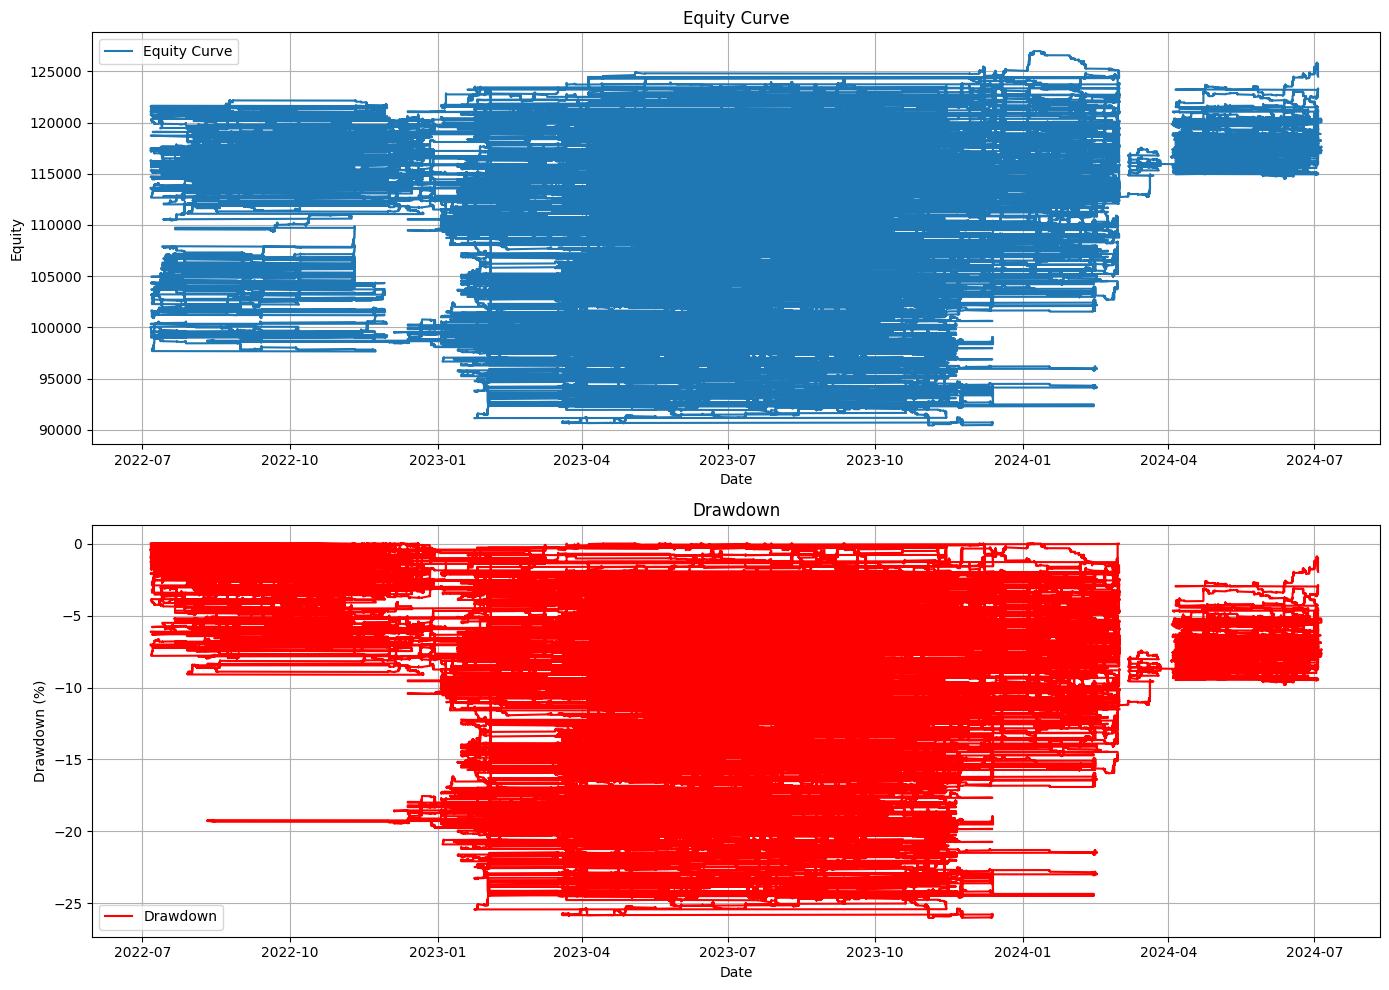

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

def download_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    return data

def find_support_resistance_zones(price_data, epsilon=0.1, min_samples=3, tolerance=0.002):
    price_data['min'] = price_data['Low'][(price_data['Low'].shift(1) > price_data['Low']) &
                                          (price_data['Low'].shift(-1) > price_data['Low'])]
    price_data['max'] = price_data['High'][(price_data['High'].shift(1) < price_data['High']) &
                                           (price_data['High'].shift(-1) < price_data['High'])]

    pivots = pd.concat([price_data['min'].dropna(), price_data['max'].dropna()]).sort_index()

    if pivots.empty:
        print("No pivot points found. Adjust the date range or pivot point identification logic.")
        return None

    pivot_levels = pivots.values.reshape(-1, 1)
    clustering = DBSCAN(eps=epsilon, min_samples=min_samples).fit(pivot_levels)
    pivot_levels = pd.DataFrame(pivot_levels, index=pivots.index, columns=['Price'])
    pivot_levels['Cluster'] = clustering.labels_

    clustered_levels = pivot_levels[pivot_levels['Cluster'] != -1]

    support_resistance = clustered_levels.groupby('Cluster')['Price'].agg(['mean', 'min', 'max', 'count'])
    support_resistance.columns = ['Level', 'Min', 'Max', 'Frequency']

    support_resistance['Support_Zone_Lower'] = support_resistance['Min'] * (1 - tolerance)
    support_resistance['Support_Zone_Upper'] = support_resistance['Max'] * (1 + tolerance)
    support_resistance['Resistance_Zone_Lower'] = support_resistance['Min'] * (1 - tolerance)
    support_resistance['Resistance_Zone_Upper'] = support_resistance['Max'] * (1 + tolerance)

    return support_resistance

def simulate_trades(price_data, support_resistance_zones, initial_capital=100000, trade_fraction=0.10, sl_percent=0.236, tp_percent=0.786):
    equity = initial_capital
    trades = []
    total_traded_volume = 0
    sl_hits = 0
    tp_hits = 0
    total_trades = 0

    for idx, row in tqdm(support_resistance_zones.iterrows(), total=support_resistance_zones.shape[0], desc="Simulating Trades"):
        support_entry = row['Support_Zone_Lower']
        support_exit = support_entry + tp_percent * (row['Support_Zone_Upper'] - row['Support_Zone_Lower'])
        support_sl = support_entry - sl_percent * (row['Support_Zone_Upper'] - row['Support_Zone_Lower'])

        resistance_entry = row['Resistance_Zone_Upper']
        resistance_exit = resistance_entry - tp_percent * (row['Resistance_Zone_Upper'] - row['Resistance_Zone_Lower'])
        resistance_sl = resistance_entry + sl_percent * (row['Resistance_Zone_Upper'] - row['Resistance_Zone_Lower'])

        for i in range(len(price_data)):
            if price_data['Close'][i] >= support_entry and price_data['Close'][i] <= row['Support_Zone_Upper']:
                entry_price = price_data['Close'][i]
                trade_amount = equity * trade_fraction
                total_traded_volume += trade_amount
                total_trades += 1
                for j in range(i + 1, len(price_data)):
                    if price_data['Close'][j] >= support_exit:
                        exit_price = price_data['Close'][j]
                        profit = (exit_price - entry_price) * (trade_amount / entry_price)
                        equity += profit
                        trades.append({
                            'Entry_Date': price_data.index[i],
                            'Entry': entry_price,
                            'Exit_Date': price_data.index[j],
                            'Exit': exit_price,
                            'Type': 'Support',
                            'Profit': profit
                        })
                        tp_hits += 1
                        break
                    elif price_data['Close'][j] <= support_sl:
                        exit_price = price_data['Close'][j]
                        loss = (entry_price - exit_price) * (trade_amount / entry_price)
                        equity -= loss
                        trades.append({
                            'Entry_Date': price_data.index[i],
                            'Entry': entry_price,
                            'Exit_Date': price_data.index[j],
                            'Exit': exit_price,
                            'Type': 'Support',
                            'Profit': -loss
                        })
                        sl_hits += 1
                        break

            if price_data['Close'][i] <= resistance_entry and price_data['Close'][i] >= row['Resistance_Zone_Lower']:
                entry_price = price_data['Close'][i]
                trade_amount = equity * trade_fraction
                total_traded_volume += trade_amount
                total_trades += 1
                for j in range(i + 1, len(price_data)):
                    if price_data['Close'][j] <= resistance_exit:
                        exit_price = price_data['Close'][j]
                        profit = (entry_price - exit_price) * (trade_amount / entry_price)
                        equity += profit
                        trades.append({
                            'Entry_Date': price_data.index[i],
                            'Entry': entry_price,
                            'Exit_Date': price_data.index[j],
                            'Exit': exit_price,
                            'Type': 'Resistance',
                            'Profit': profit
                        })
                        tp_hits += 1
                        break
                    elif price_data['Close'][j] >= resistance_sl:
                        exit_price = price_data['Close'][j]
                        loss = (exit_price - entry_price) * (trade_amount / entry_price)
                        equity -= loss
                        trades.append({
                            'Entry_Date': price_data.index[i],
                            'Entry': entry_price,
                            'Exit_Date': price_data.index[j],
                            'Exit': exit_price,
                            'Type': 'Resistance',
                            'Profit': -loss
                        })
                        sl_hits += 1
                        break

    trades_df = pd.DataFrame(trades)
    trades_df['Cumulative_Profit'] = trades_df['Profit'].cumsum()
    trades_df['Equity'] = trades_df['Cumulative_Profit'] + initial_capital
    trades_df['Drawdown'] = trades_df['Equity'] - trades_df['Equity'].cummax()
    trades_df['Drawdown_Percent'] = trades_df['Drawdown'] / trades_df['Equity'].cummax() * 100
    max_drawdown = trades_df['Drawdown'].min()

    stats = {
        'Total_Trades': total_trades,
        'SL_Hits': sl_hits,
        'TP_Hits': tp_hits,
        'Total_Profit': trades_df['Profit'].sum(),
        'Max_Drawdown': max_drawdown,
        'Total_Traded_Volume': total_traded_volume
    }

    return trades_df, stats

def plot_trading_performance(trades_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    ax1.plot(trades_df['Exit_Date'], trades_df['Equity'], label='Equity Curve')
    ax1.set_title('Equity Curve')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Equity')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(trades_df['Exit_Date'], trades_df['Drawdown_Percent'], label='Drawdown', color='red')
    ax2.set_title('Drawdown')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def save_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Example usage
ticker = "GC=F"
period = "2y"
interval = "1h"
initial_capital = 100000  # Define your initial capital

# Download data
print("Downloading data...")
price_data = download_data(ticker, period=period, interval=interval)
save_to_file(price_data, 'price_data.pkl')

# Load data
# price_data = load_from_file('price_data.pkl')

# Find support and resistance zones
print("Calculating support and resistance zones...")
support_resistance_zones = find_support_resistance_zones(price_data)
save_to_file(support_resistance_zones, 'support_resistance_zones.pkl')

# Load support and resistance zones
# support_resistance_zones = load_from_file('support_resistance_zones.pkl')

# Simulate trades
print("Simulating trades...")
trades_df, stats = simulate_trades(price_data, support_resistance_zones, initial_capital, trade_fraction=0.10, sl_percent=0.236, tp_percent=0.786)
save_to_file(trades_df, 'trades_df.pkl')
save_to_file(stats, 'stats.pkl')

# Display trades and metrics
print(trades_df)
print(f"Total Trades: {stats['Total_Trades']}")
print(f"SL Hits: {stats['SL_Hits']}")
print(f"TP Hits: {stats['TP_Hits']}")
print(f"Total Profit: {stats['Total_Profit']:.2f}")
print(f"Max Drawdown: {stats['Max_Drawdown']:.2f}")
print(f"Total Traded Volume: {stats['Total_Traded_Volume']:.2f}")

# Plot trading performance
plot_trading_performance(trades_df)
